In [ ]:
# clear python cache pre-training
import shutil
from pathlib import Path

# remove all __pycache__ directories
cache_dirs = list(Path.cwd().parent.rglob("__pycache__"))
if cache_dirs:
    for cache_dir in cache_dirs:
        shutil.rmtree(cache_dir)
    print(f"cleared {len(cache_dirs)} __pycache__ directories")
else:
    print("No __pycache__ directories found")

# also remove old model checkpoints if fresh start is desired
old_checkpoints = list(Path("../models").glob("*.pt"))
if old_checkpoints:
    for ckpt in old_checkpoints:
        ckpt.unlink()
    print(f"Removed {len(old_checkpoints)} old checkpoints")
else:
    print("No old checkpoints to remove")

print("\nClean slate ready for training")

✓ No __pycache__ directories found
✓ No old checkpoints to remove

Clean slate ready for training!


In [ ]:
# import and setup
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import platform

# project root to path
project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.insert(0, str(src_path))

# modules
from data_loader import create_dataloaders
from classical_model import CNNAutoencoder, create_optimizer, create_loss_function

# seeds
torch.manual_seed(67)
np.random.seed(67)

print("="*60)
print("CNN AUTOENCODER TRAINING FOR M87* FLARE DETECTION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(platform.processor())

CNN AUTOENCODER TRAINING FOR M87* FLARE DETECTION
PyTorch version: 2.9.1+cpu
AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD


In [ ]:
# hyperparameters
CONFIG = {
    "latent_dim": 64,           # bottleneck size
    "batch_size": 64,           # balanced for 1000 training samples
    "learning_rate": 0.001,     # conservative for stability
    "epochs": 20,              # amount of training
    "patience": 15,             # early stopping
    "weight_decay": 1e-4,       # L2 regularization
    "data_dir": "../data/processed",
    "model_save_path": "../models/classical_cnn_final.pt",
    "checkpoint_dir": "../models",
}

print("[CONFIG] Hyperparameters:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

[CONFIG] Hyperparameters:
  latent_dim: 64
  batch_size: 64
  learning_rate: 0.001
  epochs: 20
  patience: 15
  weight_decay: 0.0001
  data_dir: ../data/processed
  model_save_path: ../models/classical_cnn_final.pt
  checkpoint_dir: ../models


In [ ]:
# load data
print("\n[DATA] Loading train/val/test loaders...")

train_loader, val_loader, test_loader = create_dataloaders(
    data_dir=CONFIG["data_dir"],
    batch_size=CONFIG["batch_size"],
    num_workers=4
)

# verify split sizes
print(f"\n[SPLIT SUMMARY]")
print(f"Train: {len(train_loader.dataset)} normal samples")
print(f"Val: {len(val_loader.dataset)} normal samples")  
print(f"Test: {len(test_loader.dataset)} samples (700 normal + 200 flare)")

# inspect one batch
images, labels = next(iter(train_loader))
print(f"\n[BATCH] Shape: {images.shape}")
print(f"[BATCH] Labels sample: {labels[:10]} (should all be 0)")


[DATA] Loading train/val/test loaders...
[M87FlareDataset] Loaded 1000 train samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 300 val samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 900 test samples
[M87FlareDataset] Flare count: 200

[SPLIT SUMMARY]
Train: 1000 samples (normal only)
Val:   300 samples (normal only)
Test:  900 samples (normal + flare)

[SPLIT SUMMARY]
Train: 1000 normal samples
Val: 300 normal samples
Test: 900 samples (700 normal + 200 flare)

[BATCH] Shape: torch.Size([64, 1, 128, 128])
[BATCH] Labels sample: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) (should all be 0)


In [ ]:
# initialize model
print("\n" + "="*60)
print("MODEL INITIALIZATION")
print("="*60)

model = CNNAutoencoder(latent_dim=CONFIG["latent_dim"])

# count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[MODEL] Trainable parameters: {total_params:,}")

# initialize optimizer and loss
optimizer = create_optimizer(model, learning_rate=CONFIG["learning_rate"])
criterion = create_loss_function()

print(f"[MODEL] Optimizer: {optimizer.__class__.__name__}")
print(f"[MODEL] Loss: {criterion.__class__.__name__}")

# create checkpoint directory
Path(CONFIG["checkpoint_dir"]).mkdir(exist_ok=True)


MODEL INITIALIZATION
[MODEL] Trainable parameters: 85,185
[MODEL] Optimizer: AdamW
[MODEL] Loss: MSELoss


In [ ]:
# training loop
print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)

def train_one_epoch():
    """Train one epoch on NORMAL images only"""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # train only on normal images
        normal_mask = (labels == 0)
        normal_images = images[normal_mask]
        
        if normal_images.shape[0] == 0:
            continue
        
        # forward
        reconstructed, _ = model(normal_images)
        loss = criterion(reconstructed, normal_images)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"  Batch [{batch_idx}/{len(train_loader)}] | Loss: {loss.item():.6f}")
    
    return total_loss / num_batches


def validate():
    """Validate on NORMAL images only"""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            normal_mask = (labels == 0)
            normal_images = images[normal_mask]
            
            if normal_images.shape[0] == 0:
                continue
            
            reconstructed, _ = model(normal_images)
            loss = criterion(reconstructed, normal_images)
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches


# training metrics storage
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch [{epoch+1}/{CONFIG['epochs']}]")
    
    # train
    train_loss = train_one_epoch()
    train_losses.append(train_loss)
    print(f"  Train Loss: {train_loss:.6f}")
    
    # validate
    val_loss = validate()
    val_losses.append(val_loss)
    print(f"  Val Loss:   {val_loss:.6f}")
    
    # early stopping
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        patience_counter = 0
        
        # save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': CONFIG,
        }, Path(CONFIG["checkpoint_dir"]) / "classical_cnn_best.pt")
        print(f"  → Saved best model")
    else:
        patience_counter += 1
        print(f"  → No improvement for {patience_counter} epochs")
        
        if patience_counter >= CONFIG["patience"]:
            print(f"\n[EARLY STOPPING] Triggered at epoch {epoch+1}")
            break

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)


TRAINING STARTED

Epoch [1/20]
  Batch [0/16] | Loss: 0.163542
  Batch [10/16] | Loss: 0.017087
  Train Loss: 0.028998
  Val Loss:   0.051377
  → Saved best model

Epoch [2/20]
  Batch [0/16] | Loss: 0.014996
  Batch [10/16] | Loss: 0.009070
  Train Loss: 0.010743
  Val Loss:   0.028186
  → Saved best model

Epoch [3/20]
  Batch [0/16] | Loss: 0.005696
  Batch [10/16] | Loss: 0.007108
  Train Loss: 0.008293
  Val Loss:   0.006570
  → Saved best model

Epoch [4/20]
  Batch [0/16] | Loss: 0.004421
  Batch [10/16] | Loss: 0.003131
  Train Loss: 0.003649
  Val Loss:   0.003580
  → Saved best model

Epoch [5/20]
  Batch [0/16] | Loss: 0.002107
  Batch [10/16] | Loss: 0.000713
  Train Loss: 0.001018
  Val Loss:   0.001787
  → Saved best model

Epoch [6/20]
  Batch [0/16] | Loss: 0.000515
  Batch [10/16] | Loss: 0.000407
  Train Loss: 0.000445
  Val Loss:   0.000577
  → Saved best model

Epoch [7/20]
  Batch [0/16] | Loss: 0.000341
  Batch [10/16] | Loss: 0.000272
  Train Loss: 0.000291
  Va

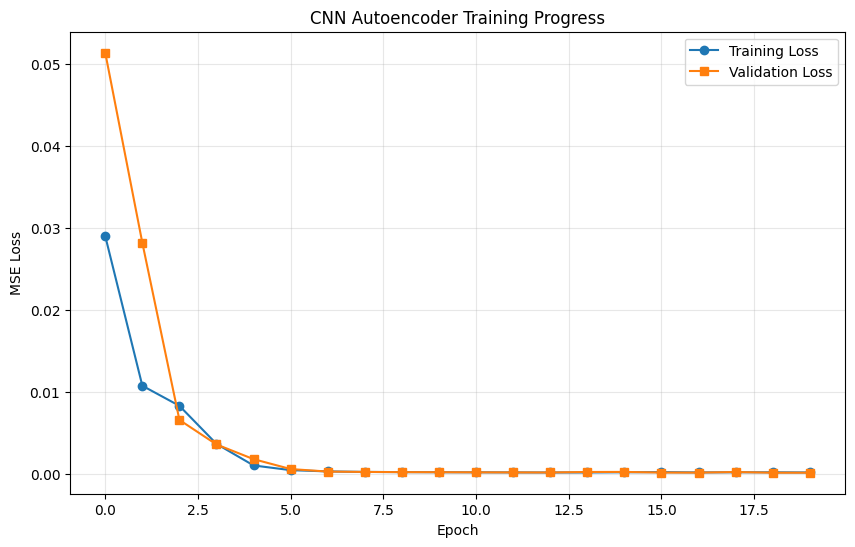

[PLOT] Saved training curve to ../figures/training_curve.png


In [ ]:
# training curve plot
fig_path = "../figures/training_curve.png"
Path(fig_path).parent.mkdir(exist_ok=True)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN Autoencoder Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"[PLOT] Saved training curve to {fig_path}")


EVALUATION ON TEST SET
[EVAL] Test samples: 900
[EVAL] Normal: 700, Flare: 200

ROC AUC: 0.9777


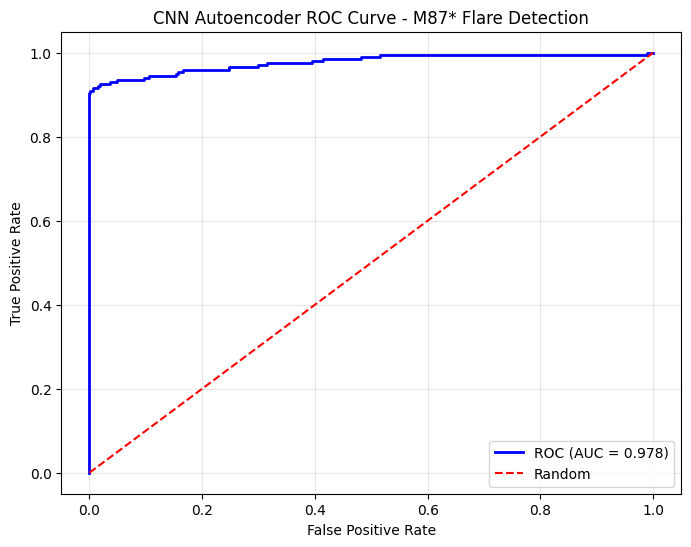

[PLOT] Saved ROC curve to ../figures/roc_classical.png


In [ ]:
# load best model and evaluate on test set
print("\n" + "="*60)
print("EVALUATION ON TEST SET")
print("="*60)

# load best checkpoint
checkpoint = torch.load(Path(CONFIG["checkpoint_dir"]) / "classical_cnn_best.pt", 
                        map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])

# compute anomaly scores for ALL test samples
all_errors = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        errors = model.get_reconstruction_error(images)
        all_errors.extend(errors.numpy())
        all_labels.extend(labels.numpy())

all_errors = np.array(all_errors)
all_labels = np.array(all_labels)

print(f"[EVAL] Test samples: {len(all_errors)}")
print(f"[EVAL] Normal: {(all_labels == 0).sum()}, Flare: {(all_labels == 1).sum()}")

# compute ROC AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
roc_auc = roc_auc_score(all_labels, all_errors)

print(f"\n{'='*40}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"{'='*40}")

# plot ROC curve
fig_path = "../figures/roc_classical.png"
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', ls='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Autoencoder ROC Curve - M87* Flare Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"[PLOT] Saved ROC curve to {fig_path}")

In [ ]:
# optimal threshold and detection metrics
print("\n" + "="*60)
print("DETECTION METRICS AT OPTIMAL THRESHOLD")
print("="*60)

# Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At threshold: TPR={tpr[optimal_idx]:.3f}, FPR={fpr[optimal_idx]:.3f}")

# apply threshold
predictions = (all_errors > optimal_threshold).astype(int)

# compute metrics
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"\nPrecision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")


DETECTION METRICS AT OPTIMAL THRESHOLD
Optimal threshold: 0.0001
At threshold: TPR=0.915, FPR=0.006

Precision: 0.978
Recall: 0.910
F1-Score: 0.943


In [ ]:
# save final model and metrics
final_metrics = {
    "roc_auc": float(roc_auc),
    "optimal_threshold": float(optimal_threshold),
    "tpr": float(tpr[optimal_idx]),
    "fpr": float(fpr[optimal_idx]),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "train_val_split": "1000 normal / 300 normal",
    "test_split": "700 normal + 200 flare",
    "total_parameters": int(total_params),
    "epochs_trained": len(train_losses),
    "final_val_loss": float(val_losses[-1]),
}

# Save model
torch.save(model.state_dict(), CONFIG["model_save_path"])
print(f"\n[SAVED] Final model: {CONFIG['model_save_path']}")

# Save metrics
metrics_path = "../figures/classical_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(final_metrics, f, indent=2)
print(f"[SAVED] Metrics: {metrics_path}")


[SAVED] Final model: ../models/classical_cnn_final.pt
[SAVED] Metrics: ../figures/classical_metrics.json


In [4]:
# double check data leakage
print("="*60)
print("VERIFYING TEST SET INTEGRITY")
print("="*60)

# load test loader
_, _, test_loader = create_dataloaders(data_dir="../data/processed", batch_size=64)

# check if any test sample appears in train/val
test_files = set()
for item in test_loader.dataset.file_list:
    test_files.add(item["path"])

train_val_files = set()
for split in ["train", "val"]:
    with open(f"../data/processed/splits/{split}_files.json") as f:
        for item in json.load(f):
            train_val_files.add(item["path"])

leakage = test_files & train_val_files
print(f"Test files overlapping train/val: {len(leakage)} (should be 0)")

if len(leakage) == 0:
    print("No data leakage, results are valid")
else:
    print("Data leakage detected!")

VERIFYING TEST SET INTEGRITY
[M87FlareDataset] Loaded 1000 train samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 300 val samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 900 test samples
[M87FlareDataset] Flare count: 200

[SPLIT SUMMARY]
Train: 1000 samples (normal only)
Val:   300 samples (normal only)
Test:  900 samples (normal + flare)
Test files overlapping train/val: 0 (should be 0)
No data leakage, results are valid
